In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import os
import os.path as osp
import json
import math
from glob import glob
from pprint import pprint

import torch
import matplotlib.pyplot as plt
import numpy as np
import cv2
import albumentations as A
import lanms
from albumentations.pytorch import ToTensorV2
from imageio import imread

from model import EAST
from detect import detect

In [4]:
DATASET_DIR = '/opt/ml/input/data/ICDAR17_Korean'  # FIXME

In [5]:
ufo_fpath = osp.join(DATASET_DIR, 'ufo/train.json')
print(ufo_fpath)
with open(ufo_fpath, 'r') as f:
    ufo_anno = json.load(f)

/opt/ml/input/data/ICDAR17_Korean/ufo/train.json


In [6]:
def draw_bbox(image, bbox, color=(0, 0, 255), thickness=1, thickness_sub=None, double_lined=False,
              write_point_numbers=False):
    """이미지에 하나의 bounding box를 그려넣는 함수
    """
    thickness_sub = thickness_sub or thickness * 3
    basis = max(image.shape[:2])
    fontsize = basis / 1500
    x_offset, y_offset = int(fontsize * 12), int(fontsize * 10)
    color_sub = (255 - color[0], 255 - color[1], 255 - color[2])

    points = [(int(np.rint(p[0])), int(np.rint(p[1]))) for p in bbox]

    for idx in range(len(points)):
        if double_lined:
            cv2.line(image, points[idx], points[(idx + 1) % len(points)], color_sub,
                     thickness=thickness_sub)
        cv2.line(image, points[idx], points[(idx + 1) % len(points)], color, thickness=thickness)

    if write_point_numbers:
        for idx in range(len(points)):
            loc = (points[idx][0] - x_offset, points[idx][1] - y_offset)
            if double_lined:
                cv2.putText(image, str(idx), loc, cv2.FONT_HERSHEY_SIMPLEX, fontsize, color_sub,
                            thickness_sub, cv2.LINE_AA)
            cv2.putText(image, str(idx), loc, cv2.FONT_HERSHEY_SIMPLEX, fontsize, color, thickness,
                        cv2.LINE_AA)


def draw_bboxes(image, bboxes, color=(0, 0, 255), thickness=1, thickness_sub=None,
                double_lined=False, write_point_numbers=False):
    """이미지에 다수의 bounding box들을 그려넣는 함수
    """
    for bbox in bboxes:
        draw_bbox(image, bbox, color=color, thickness=thickness, thickness_sub=thickness_sub,
                  double_lined=double_lined, write_point_numbers=write_point_numbers)
        

def gray_mask_to_heatmap(x):
    x = cv2.cvtColor(cv2.applyColorMap(x, cv2.COLORMAP_JET), cv2.COLOR_BGR2RGB)
    return x


def get_superimposed_image(image, score_map, heatmap=True, w_image=None, w_map=None):
    """이미지에 map/mask 등을 중첩하여 그려주는 함수
    
    Args:
        image (ndarray): (H, W, C) shaped, float32 or uint8 dtype is allowed.
        score_map (ndarray): (H, W) shaped, float32 or uint8 dtype is allowed.
        heatmap (boot): Wheather to convert `score_map` into a heatmap.
        w_image (float)
        w_map (float)

    Blending weights(`w_image` and `w_map`) are default to (0.4, 0.6).
    """

    assert w_image is None or (w_image > 0 and w_image < 1)
    assert w_map is None or (w_map > 0 and w_map < 1)

    if image.dtype != np.uint8:
        image = (255 * np.clip(image, 0, 1)).astype(np.uint8)

    if score_map.dtype != np.uint8:
        score_map = (255 * np.clip(score_map, 0, 1)).astype(np.uint8)
    if heatmap:
        score_map = gray_mask_to_heatmap(score_map)
    elif score_map.ndim == 2 or score_map.shape[2] != 3:
        score_map = cv2.cvtColor(score_map, cv2.COLOR_GRAY2RGB)

    if w_image is None and w_map is None:
        w_image, w_map = 0.4, 0.6
    elif w_image is None:
        w_image = 1 - w_map
    elif w_map is None:
        w_map = 1 - w_image

    return cv2.addWeighted(image, w_image, score_map, w_map, 0)

In [7]:
from dataset import SceneTextDataset
from east_dataset import EASTDataset
from model import EAST
from inference import do_inference
from deteval import calc_deteval_metrics
from torch.utils.data import DataLoader

Original image:	(2268, 3024, 3)


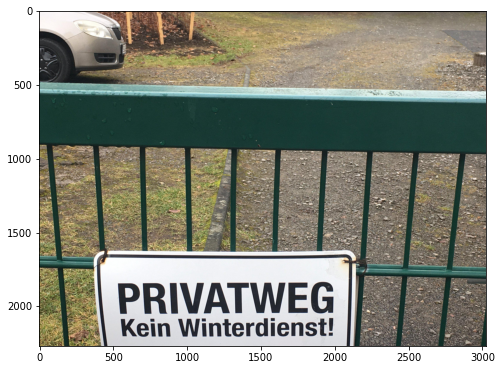

In [8]:
image = imread('/opt/ml/input/data/ICDAR17_Korean/images/img_992.jpg')
orig_size = image.shape[:2]
print('Original image:\t{}'.format(image.shape))

plt.figure(figsize=(8,8))
plt.imshow(image)

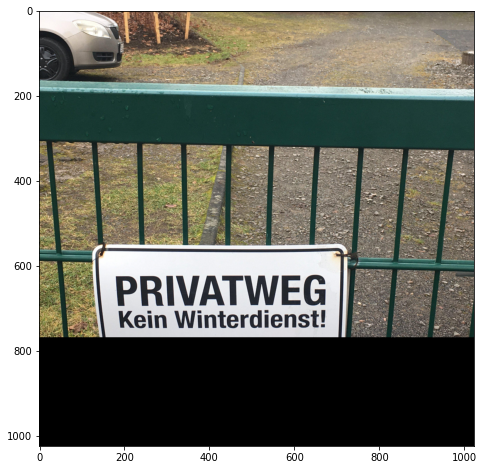

In [9]:
INPUT_SIZE = 1024

prep_fn = A.Compose([
    A.LongestMaxSize(INPUT_SIZE),
    A.PadIfNeeded(min_height=INPUT_SIZE, min_width=INPUT_SIZE, position=A.PadIfNeeded.PositionType.TOP_LEFT, border_mode=cv2.BORDER_CONSTANT),
    A.Normalize(), ToTensorV2()
])

# 시각화를 위해 Normalize와 Tensorize를 제외한 버전
prep_fn_vis = A.Compose([
    A.LongestMaxSize(INPUT_SIZE),
    A.PadIfNeeded(min_height=INPUT_SIZE, min_width=INPUT_SIZE, position=A.PadIfNeeded.PositionType.TOP_LEFT, border_mode=cv2.BORDER_CONSTANT)
])

vis = prep_fn_vis(image=image)['image']
plt.figure(figsize=(8,8))
plt.imshow(vis)

In [10]:
image.shape

(2268, 3024, 3)

In [11]:
image_size, input_size, data_dir, batch_size, num_workers = 1024, 512, '/opt/ml/input/data/ICDAR17_Korean', 32, 8

In [30]:
dataset = SceneTextDataset(data_dir, split='valid', image_size=image_size, crop_size=input_size)
dataset = EASTDataset(dataset)
num_batches = math.ceil(len(dataset) / batch_size)
train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [31]:
figsize = (8,8)

In [32]:
from utils_vis import find_bbox_from_maps, draw_bboxes, get_rotate_mat

<class 'matplotlib.figure.Figure'>


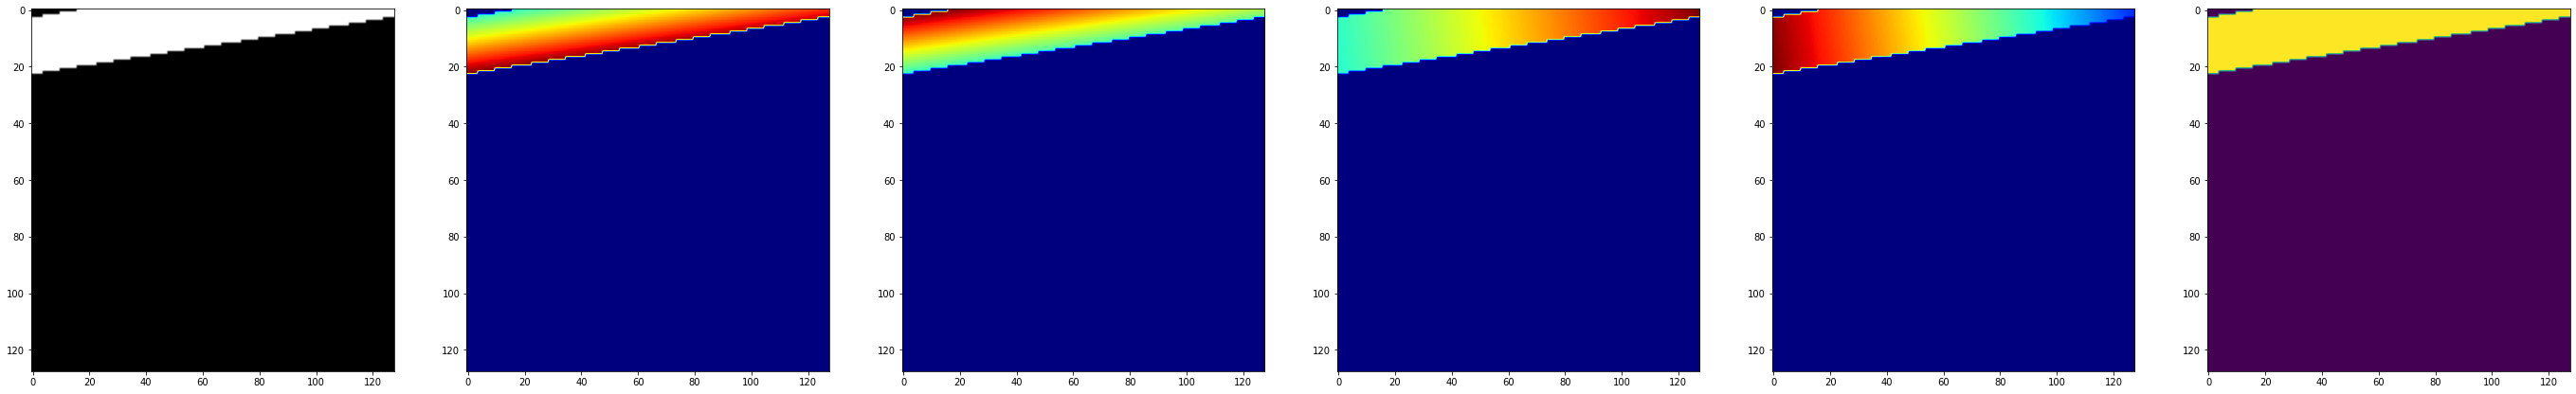

<class 'matplotlib.figure.Figure'>


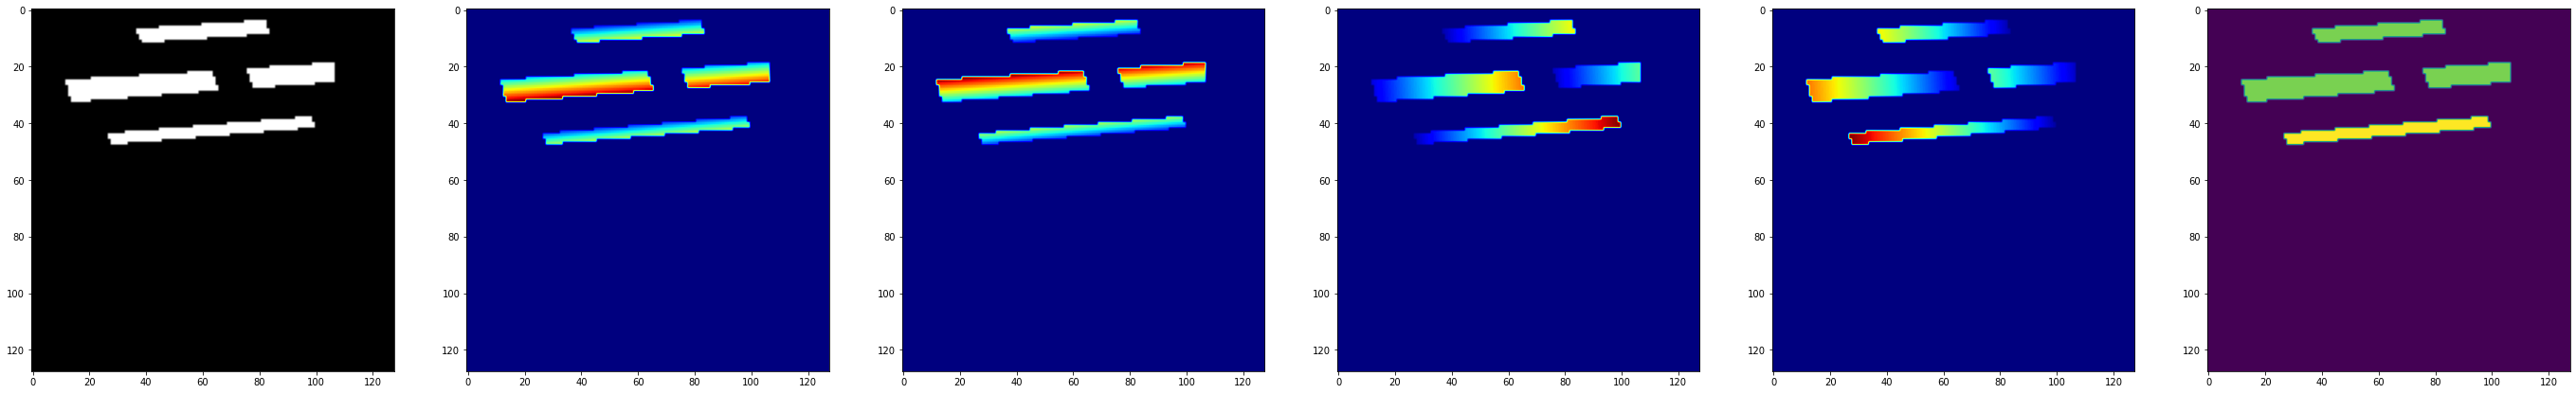

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


bbox_shape : (1137, 8)
nms bbox_shape : (4, 4, 2)


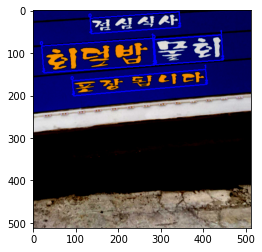

In [36]:
for i, data in enumerate(train_loader):
    if i == 1:
        break
    image, score_maps, geo_maps, roi_mask = data
    cnt = 0
    for img, score_map, geo_map in zip(image, score_maps, geo_maps):
        if cnt == 1:
            break

        score_map, geo_map = score_map.permute(1, 2, 0).cpu().numpy(), geo_map.permute(1, 2, 0).cpu().numpy()
        score_map = score_map.squeeze()
        center_mask = score_map > 0.9
        fig, axs = plt.subplots(ncols=6, nrows=1, figsize=(figsize[0] * 6, figsize[1]))
        axs[0].imshow(center_mask, cmap='gray')
        for idx in range(4):
            axs[idx + 1].imshow(geo_map[:, :, idx] * center_mask, cmap='jet')
        axs[5].imshow(geo_map[:, :, 4] * center_mask)
        print(type(fig))
        plt.show(fig)

        xy_text = np.argwhere(score_map > 0.9)[:, ::-1].copy()
        if xy_text.size == 0:
            bboxes = np.zeros((0, 4, 2), dtype=np.float32)
        else:
            xy_text = xy_text[np.argsort(xy_text[:, 1])]  # Row-wise로 정렬
            valid_pos = xy_text * 4
            valid_geo = geo_map[xy_text[:, 1], xy_text[:, 0], :]  # (n x 5)
            indices, bboxes = [], []
            for idx, ((x, y), g) in enumerate(zip(valid_pos, valid_geo)):
                y_min, y_max = y - g[0], y + g[1]
                x_min, x_max = x - g[2], x + g[3]
                rotate_mat = get_rotate_mat(-g[4])
                bbox = np.array([[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max]], dtype=np.float32)
                anchor = np.array([x, y], dtype=np.float32).reshape(2, 1)
                rotated_bbox = (np.dot(rotate_mat, bbox.T - anchor) + anchor).T
                if bbox[:, 0].min() < 0 or bbox[:, 0].max() >= score_map.shape[1] * 4:
                    continue
                elif bbox[:, 1].min() < 0 or bbox[:, 1].max() >= score_map.shape[0] * 4:
                    continue
                indices.append(idx)
                bboxes.append(rotated_bbox.flatten())
            if len(bboxes) == 0:
                continue
            bboxes = np.array(bboxes)
            print(f'bbox_shape : {bboxes.shape}')
            scored_bboxes = np.zeros((bboxes.shape[0], 9), dtype=np.float32)
            scored_bboxes[:, :8] = bboxes
            scored_bboxes[:, 8] = score_map[xy_text[indices, 1], xy_text[indices, 0]]
            nms_bboxes = lanms.merge_quadrangle_n9(scored_bboxes.astype('float32'), 0.2)
            nms_bboxes = nms_bboxes[:, :8].reshape(-1, 4, 2)
            print(f'nms bbox_shape : {nms_bboxes.shape}')
            vis = img.permute(1,2,0).cpu().numpy().copy()
            draw_bboxes(vis, nms_bboxes, thickness=2)
            
            plt.imshow(vis)

            # fig, axs = plt.subplots(ncols=5, nrows=1, figsize=(figsize[0] * 6, figsize[1]))
            # for idx in range(4):
            #     axs[idx + 1].imshow(valid_geo[:, :, idx] * center_mask, cmap='jet')
            # axs[5].imshow(geo_map[:, :, 4] * center_mask)
            # plt.show(fig)

        cnt += 1

        # bboxes = find_bbox_from_maps(score_map, geo_map, orig_size, input_size, 0.9, 0.2)
        # d_img = img.permute(1,2,0).detach().cpu().numpy()
        # plt.imshow(d_img)
        # vis = d_img.copy()
        # draw_bboxes(vis, bboxes, thickness=2)
        # plt.imshow(vis)